In [228]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, precision_score, roc_curve, recall_score, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.svm import SVC, LinearSVC #O(m**2.3 x n), O(mxn )
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier, RandomForestClassifier, BaggingClassifier, StackingClassifier, GradientBoostingClassifier #rfcl Feature Imp
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#plt.xkcd()
#plt.style.use('ggplot')
plt.rcdefaults()
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


## 1) Data Preprocessing pt 1

In [281]:
df=pd.read_csv('income_evaluation.csv')
df.columns

Index(['age', ' workclass', ' fnlwgt', ' education', ' education-num',
       ' marital-status', ' occupation', ' relationship', ' race', ' sex',
       ' capital-gain', ' capital-loss', ' hours-per-week', ' native-country',
       ' income'],
      dtype='object')

In [282]:
[df.rename(columns={col: col.split(' ')[-1]}, inplace=True) for col in df.columns]
y_train=df['income']
y_train=y_train==' >50K' #Make the output a boolean
X_train=df.drop(['income'], axis=1)
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

In [221]:
#We will use k-fold cross validation for most classifiers, but will leave a small hold-out test set nonetheless
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, test_size=.15, random_state=41)
[set_df.reset_index(drop=True, inplace=True) for set_df in [X_train, X_test, y_train, y_test]] #Let's reset the index for every set

[None, None, None, None]

In [270]:
X_train.isnull().sum().sum()

0

In [283]:
X_train.iloc[:3,:]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


In [284]:
y_train[:3]

0    False
1    False
2    False
Name: income, dtype: bool

In [285]:
X_train.info(verbose=True, null_counts=True) #No null values, so no need to handle missing data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


# 2. Data Visualization

In [287]:
#Only 24% of our training data consists of >50K$ instances, so we will likely struggle with acheiving a good recall score but will likely get good accuracy scores!
sum(y_train)/len(y_train)

0.2408095574460244

In [288]:
list_nums=[column for column in X_train.columns if X_train[column].dtype==np.dtype('int')]
list_objs=[column for column in X_train.columns if X_train[column].dtype==np.dtype('O')]

In [289]:
df_temp=pd.merge(X_train, y_train, right_index=True, left_index=True)

<AxesSubplot:>

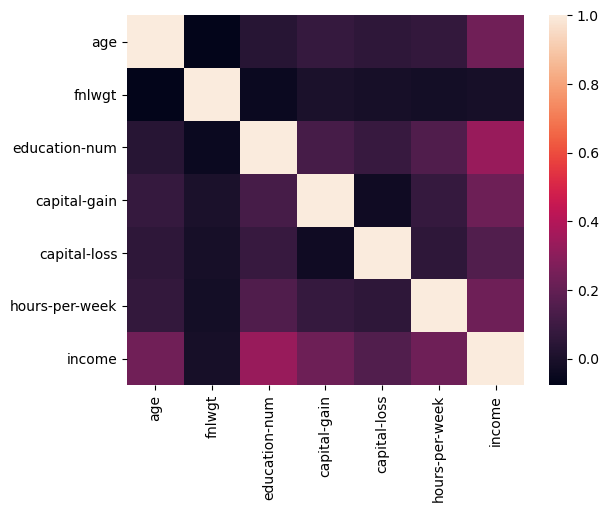

In [300]:
#Of particular interest to us in the numerical analysis, will be the education-num, age, and hours per week worked
corr_num=df_temp.corr()
sns.heatmap(corr_num)

## Age:

Mean: 38.58164675532078 
Std. dev: 13.640432553581341


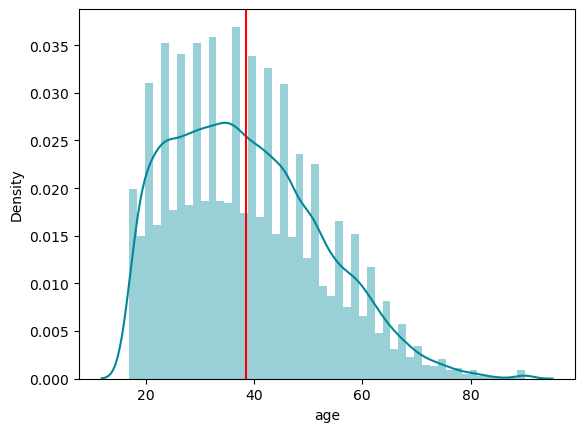

In [290]:
#The age is right-skewed for obvious reasons
sns.distplot(X_train['age'], color='#008899')
plt.axvline(X_train['age'].mean(), 0, 1, color='red')
print("Mean: {}".format(X_train['age'].mean()), "\nStd. dev: {}".format(X_train['age'].std()))

In [275]:
df_temp.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       ' income'],
      dtype='object')

<AxesSubplot:xlabel='income', ylabel='age'>

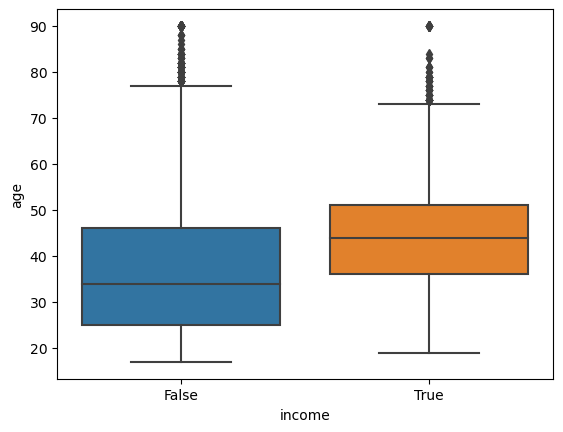

In [292]:
#As you may have already guessed, a >50K salary is correlated to a higher age, considering the median and IQR.
sns.boxplot(x='income', y='age', data=df_temp)

In [214]:
#sns.set(rc={'figure.figsize':(12:11)})
ax=sns.lineplot(x='X', y='Y_', data=raw)
ax=sns.barplot(x='X',)
ax=sns.scatterplo

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (<ipython-input-214-b28e3be777d7>, line 1)

## Hours per week worked:

Mean: 40.437455852092995 
Std. dev: 12.347428681731843


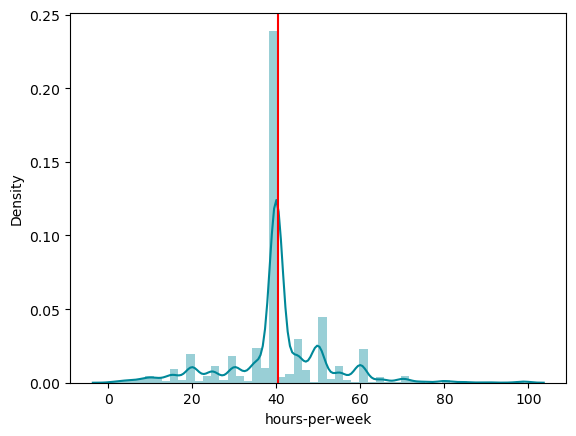

In [295]:
sns.distplot(X_train['hours-per-week'], color='#008899')
plt.axvline(X_train['hours-per-week'].mean(), 0, 1, color='red')
print("Mean: {}".format(X_train['hours-per-week'].mean()), "\nStd. dev: {}".format(X_train['hours-per-week'].std()))

<AxesSubplot:xlabel='income', ylabel='hours-per-week'>

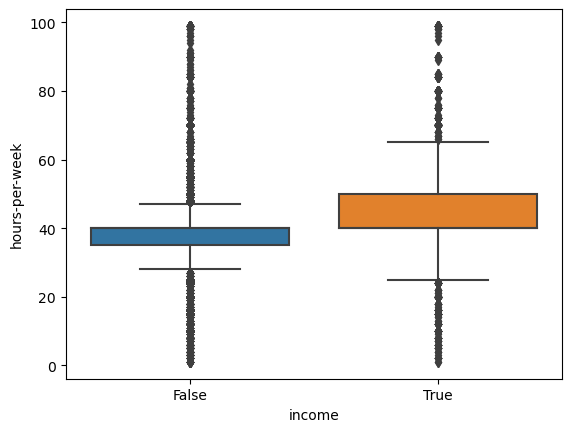

In [301]:
sns.boxplot(x='income', y='hours-per-week', data=df_temp)

## Education number of years:

Mean: 10.0806793403151 
Std. dev: 2.5727203320673877


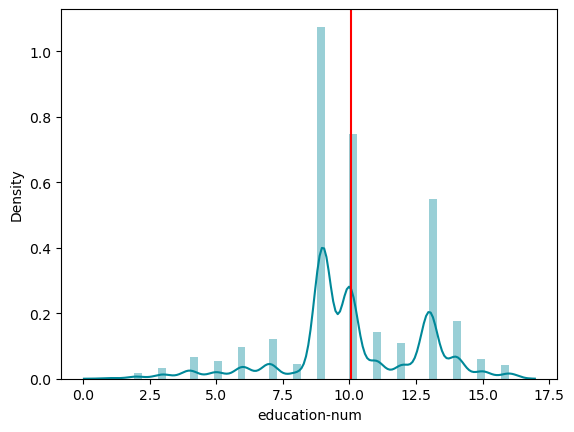

In [308]:
sns.distplot(X_train['education-num'], color='#008899')
plt.axvline(X_train['education-num'].mean(), 0, 1, color='red')
print("Mean: {}".format(X_train['education-num'].mean()), "\nStd. dev: {}".format(X_train['education-num'].std()))

<AxesSubplot:xlabel='income', ylabel='education-num'>

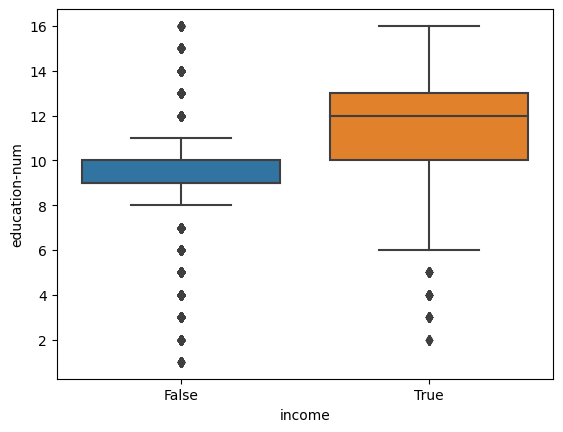

In [309]:
sns.boxplot(x='income', y='education-num', data=df_temp)

# Data Visualization: Categorical Variables 

In [320]:
list_objs

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country']

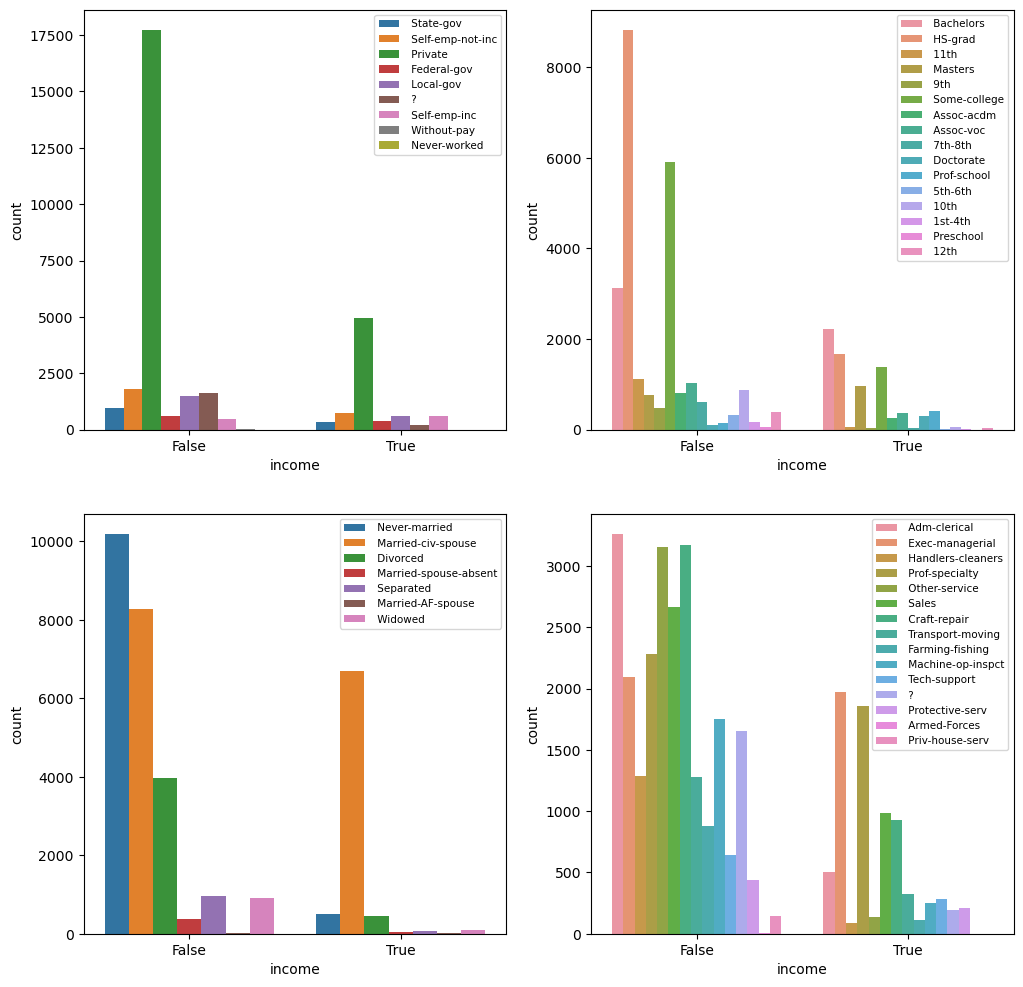

In [349]:
#It's clear that the vast majority of the people in this set are grouped into 'private'. It looks like Self-emp-inc (self employed in a business) have an advantage, but we will analyze the correlation later after One hot encoding the object variables.
#plt.legend(fontsize='small', title_fontsize='10')
fig, ax = plt.subplots(2,2, figsize=(12,12))
plot1=sns.countplot(x='income', hue='workclass', data=df_temp, ax=ax[0,0])
plot1.legend(loc='upper right',fontsize = 7.5)
plot2=sns.countplot(x='income', hue='education', data=df_temp, ax=ax[0,1])
plot2.legend(fontsize = 7.5, loc='upper right')
plot3=sns.countplot(x='income', hue='marital-status', data=df_temp, ax=ax[1,0])
plot3.legend(loc='upper right', fontsize = 7.5)
plot4=sns.countplot(x='income', hue='occupation', data=df_temp, ax=ax[1,1])
plot4.legend(fontsize = 7.5, loc='upper right')

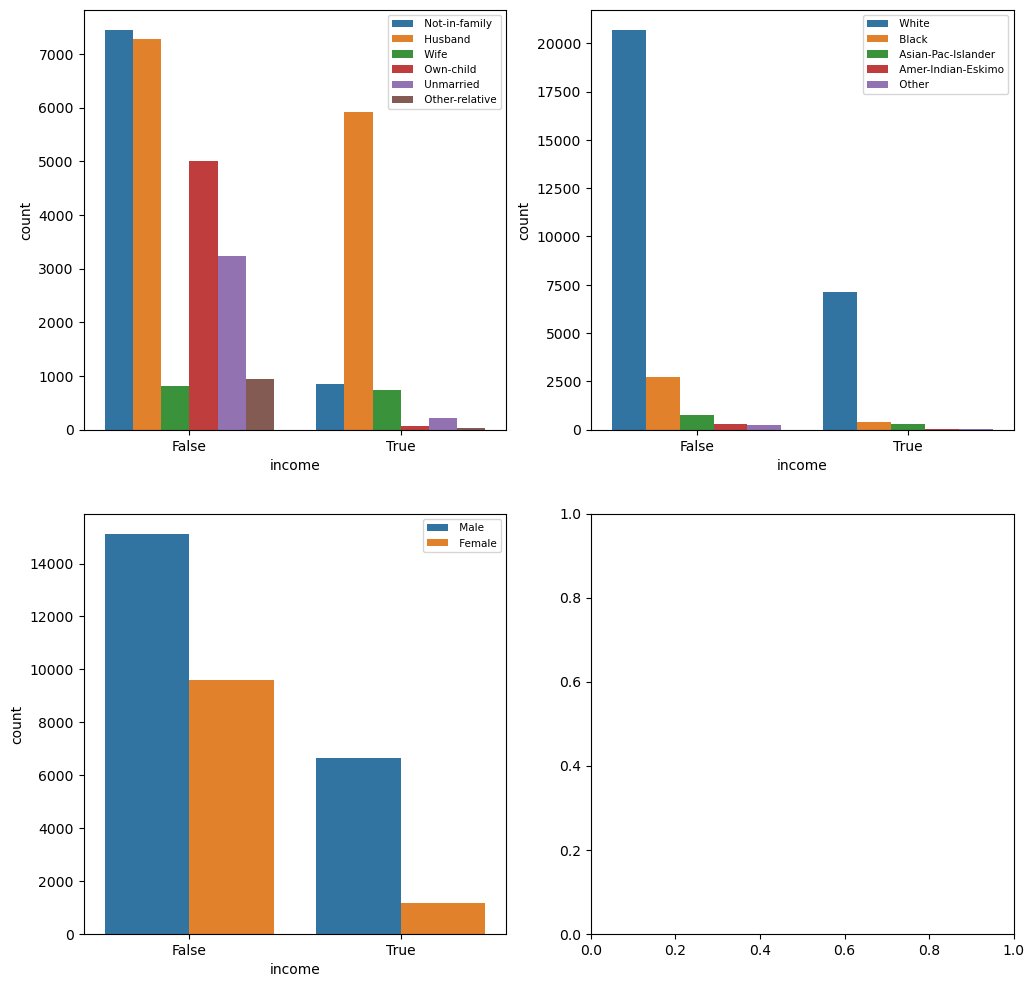

In [351]:
fig, ax = plt.subplots(2,2, figsize=(12,12))
plot1=sns.countplot(x='income', hue='relationship', data=df_temp, ax=ax[0,0])
plot1.legend(loc='upper right',fontsize = 7.5)
plot2=sns.countplot(x='income', hue='race', data=df_temp, ax=ax[0,1])
plot2.legend(fontsize = 7.5, loc='upper right')
plot3=sns.countplot(x='income', hue='sex', data=df_temp, ax=ax[1,0])
plot3.legend(loc='upper right', fontsize = 7.5)

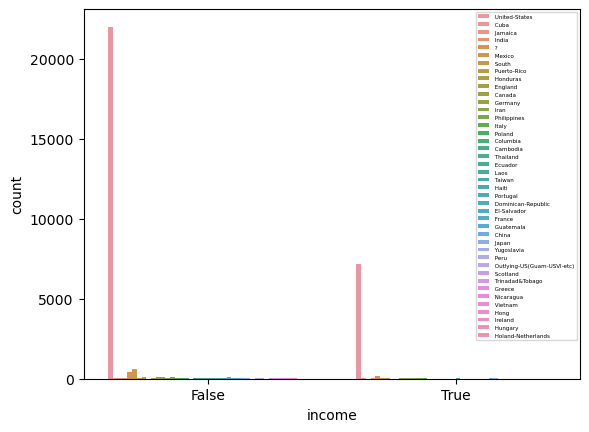

In [357]:
plot4=sns.countplot(x='income', hue='native-country', data=df_temp)
plot4.legend(fontsize = 4, loc='upper right')

# 3. Data Preprocessing pt. 2

In [117]:
#Use this for faster processing. We will be analyzing the columns however, so we will transform back to a dataframe.
def ohe_to_array(df):
    col_transformer_min_max=ColumnTransformer([('one_hot', OneHotEncoder(), list_objs),
                                            ('min_max', MinMaxScaler(), list_nums)])
    sparse_arr=col_transformer_min_max.fit_transform(df)
    train_data=sparse_arr.toarray()
    return train_data

In [118]:
#Now we one-hot encode our data

def ohe_to_df(X_train, X_test):
    global list_objs, list_nums
    list_nums=[column for column in X_train.columns if X_train[column].dtype==np.dtype('int')]
    list_objs=[column for column in X_train.columns if X_train[column].dtype==np.dtype('O')]
    ohe=OneHotEncoder()
    arr1_sparse=ohe.fit_transform(X_train[list_objs])
    arr2_sparse=ohe.transform(X_test[list_objs])
    arr1=arr1_sparse.toarray()
    arr2=arr2_sparse.toarray()
    df1=pd.DataFrame(arr1, columns=ohe.get_feature_names())
    df2=pd.DataFrame(arr2, columns=ohe.get_feature_names())
    X_train=pd.merge(df1,X_train[list_nums], left_index=True, right_index=True)
    X_test=pd.merge(df2,X_test[list_nums], left_index=True, right_index=True)
    return X_train, X_test

def rename_columns(X_train, X_test):
    for i in X_train.columns:
        if len(i.split('_'))>1:
            try:
                index=int(i.split('_')[0][-1])
                X_train.rename(columns= { i : '{}_'.format(list_objs[index]) + i.split('_')[-1]} ,inplace=True)
                X_test.rename(columns= { i : '{}_'.format(list_objs[index]) + i.split('_')[-1]} ,inplace=True)
            except Exception as x:
                print(x)

X_train, X_test=ohe_to_df(X_train,X_test)
rename_columns(X_train, X_test)
X_train.iloc[0:3]

,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 10th,...,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,59,160662,9,2407,0,60
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,50,209320,13,0,0,40
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,47,228372,14,0,0,48


## Dimensionality reduction and Data analysis

In [123]:
corr_arr=X_train.corrwith(y_train)
dict_index={}
list_keywords=[' workclass_',' education_',' marital-status_', ' occupation_',' relationship_',' race_',' sex_', ' native-country_', 'age',' fnlwgt', ' education-num', ' capital-gain', ' capital-loss',
       ' hours-per-week']
for i in list_keywords:
    dict_index[i]=[(ind, round(corr_arr[ind],2)) for ind in corr_arr.index if i in ind]

### Working Class:

In [124]:
#Interestingly enough, whether or not someone is self employed in a corporate entity setting, is the best predictor of whether or not you will be payed more than $50K:
dict_index[' workclass_']

[(' workclass_ ?', -0.08),
 (' workclass_ Federal-gov', 0.06),
 (' workclass_ Local-gov', 0.03),
 (' workclass_ Never-worked', -0.01),
 (' workclass_ Private', -0.08),
 (' workclass_ Self-emp-inc', 0.14),
 (' workclass_ Self-emp-not-inc', 0.03),
 (' workclass_ State-gov', 0.02),
 (' workclass_ Without-pay', -0.01)]

In [ ]:
fig, ax =plt.subplots()

In [125]:
#It's clear that getting a Masters, Bachelors, or Doctorate, is of utmost importance if you want to make a decent wage above $50K
dict_index[' education_']

[(' education_ 10th', -0.07),
 (' education_ 11th', -0.09),
 (' education_ 12th', -0.05),
 (' education_ 1st-4th', -0.03),
 (' education_ 5th-6th', -0.05),
 (' education_ 7th-8th', -0.06),
 (' education_ 9th', -0.06),
 (' education_ Assoc-acdm', 0.01),
 (' education_ Assoc-voc', 0.01),
 (' education_ Bachelors', 0.18),
 (' education_ Doctorate', 0.13),
 (' education_ HS-grad', -0.13),
 (' education_ Masters', 0.18),
 (' education_ Preschool', -0.02),
 (' education_ Prof-school', 0.16),
 (' education_ Some-college', -0.06)]

In [126]:
#Perhaps it's good to marry, or perhaps the younger folk who make less money simply are creating a bias in our data. What is surprising, however, is that income is correlated to whether or not your spouse is in the armed forces, a civilian, or if you divorced.
dict_index[' marital-status_']

[(' marital-status_ Divorced', -0.13),
 (' marital-status_ Married-AF-spouse', 0.01),
 (' marital-status_ Married-civ-spouse', 0.45),
 (' marital-status_ Married-spouse-absent', -0.04),
 (' marital-status_ Never-married', -0.32),
 (' marital-status_ Separated', -0.07),
 (' marital-status_ Widowed', -0.07)]

I'm not going to show the output for the rest, for the sake of keeping the notebook neat, but it's easy to see/verify that:
Being in an executive/managerial position or having a specialty job, being a male in a relationship, being white (has a slight correlation), being from the United States (especially not being from Mexico),
level of education, capital gain/loss, age, and hours worked per week is the most correlated with having a >50K salary. Surprisingly, whether or not you were a male, and whether or not you were currently married to a civilian, had the greatest correlation to the higher salary.

In [127]:
columns_keep=list(corr_arr[abs(corr_arr)>0.1].index) #If they have an absolute value of greater than .1:
X_train=X_train[columns_keep]
X_test=X_test[columns_keep]

We have reduced the number of features by 84 (108 to 24)! As we will see, the performance is nearly identical despite having nearly 1/5th of the dimensions

## Classification:
LogisticRegression:

In [156]:
def plt_roc(fpr, tpr, label):
    plt.plot(fpr, tpr, label=label)
    plt.legend()
    plt.title('train set')
    plt.show()

def show_scores(model,X_train,y_train,X_test,y_test):
    y_pred_train=model.predict(X_train)
    y_pred_test=model.predict(X_test)
    print('Accuracy on train set = ',accuracy_score(y_train, y_pred_train))
    print('Recall on train set = ',recall_score(y_train, y_pred_train))
    print('Precision on train set = ',precision_score(y_train, y_pred_train), '\n')
    print('Accuracy on test set = ',accuracy_score(y_test, y_pred_test))
    print('Recall on test set = ',recall_score(y_test, y_pred_test))
    print('Precision on test set = ',precision_score(y_test, y_pred_test,'\n'))

    try:
        y_scores=model.decision_function(X_train)
        fpr,tpr, thresholds=roc_curve(y_pred_train, y_scores)
        label=list(model.best_estimator_.named_steps.keys())[-1]
        plt_roc(fpr, tpr, label)
        print('Area under curve for train set:',round(roc_auc_score(y_train, y_scores),3), 'out of 1')
    except Exception as x:
        print('\n',x)

In [131]:
pipe_logreg=Pipeline([('scaler',MinMaxScaler()), ('logistic_reg', LogisticRegression(max_iter=1000))])
parameters=[{'scaler':[StandardScaler()], 'logistic_reg__penalty':['l2'], 'logistic_reg__C':[1,0.1,1e-2,1e-3] ,'logistic_reg__tol':[1e-5, 1e-4,1e-3]},
            {'scaler':[MinMaxScaler()], 'logistic_reg__penalty':['l2'], 'logistic_reg__C':[1,0.1,1e-2,1e-3] ,'logistic_reg__tol':[1e-5, 1e-4, 1e-3]}]
grid_search_logreg = GridSearchCV( pipe_logreg, parameters, n_jobs=-1)
grid_search_logreg.fit(X_train,y_train)
grid_search_logreg.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic_reg',
                 LogisticRegression(C=0.1, max_iter=1000, tol=1e-05))])

Accuracy on train set =  0.8469431998843764
Recall on train set =  0.5770442610652663
Precision on train set =  0.7307619228576857 

Accuracy on test set =  0.8472876151484136
Recall on test set =  0.5671768707482994
Precision on test set =  0.7378318584070797


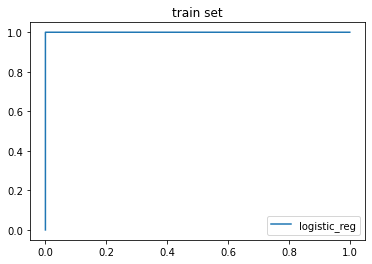

Area under curve for train set: 0.902 out of 1


In [132]:
#As you can tell, it seems that the model is struggling with identifying True positives in such a way that implies that our threshold may be too low.
show_scores(grid_search_logreg, X_train, y_train, X_test, y_test)

.852 acc. score without Dim reduction, and .847 despite nearly 1/5th of the number of features!

## SVCs:

In [135]:
pipe_SVC=Pipeline([('scaler',StandardScaler()),('svc',LinearSVC())])
##We will test between linearSVC and SVC with various kernels besides linear (since it is generally much slower)
parameters_svc=[{'scaler':[StandardScaler()], 'svc':[LinearSVC()], 'svc__penalty':['l2'], 'svc__C':[10,1,1e-1,1e-2,1e-3]},
            {'scaler':[MinMaxScaler()], 'svc':[LinearSVC()], 'svc__penalty':['l2'], 'svc__C':[10,1,1e-1,1e-2,1e-3]},
            {'scaler':[StandardScaler()], 'svc':[SVC()], 'svc__kernel':['poly', 'rbf'], 'svc__degree':[2,3], 'svc__C':[10,1,1e-1,1e-2,1e-3]},
            {'scaler':[MinMaxScaler()], 'svc':[SVC()], 'svc__kernel':['poly', 'rbf'], 'svc__degree':[2,3], 'svc__C':[10,1,1e-1,1e-2,1e-3]}]
grid_search_SVC=GridSearchCV(pipe_SVC,parameters_svc,n_jobs=-1)
grid_search_SVC.fit(X_train, y_train)
grid_search_SVC.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC(C=10, degree=2))])

Accuracy on train set =  0.8627330539095245
Recall on train set =  0.6078019504876219
Precision on train set =  0.7736822001527884 

Accuracy on test set =  0.8491299897645854
Recall on test set =  0.5748299319727891
Precision on test set =  0.7404162102957283


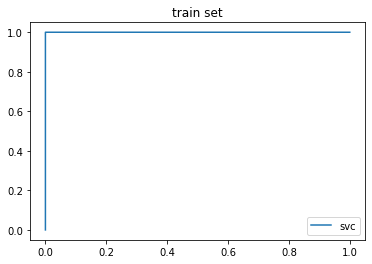

Area under curve for train set: 0.909 out of 1


In [138]:
show_scores(grid_search_SVC, X_train, y_train, X_test, y_test)

## Decision Tree

In [141]:
d_tree=DecisionTreeClassifier(criterion='gini', min_samples_split=25)
d_tree.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_split=25)

In [142]:
#Decision tree has the best results so far, but it appears like it may overfit significantly
show_scores(d_tree, X_train, y_train, X_test, y_test)

Accuracy on train set =  0.8932649226766873
Recall on train set =  0.6979744936234058
Precision on train set =  0.8317539781870195 

Accuracy on test set =  0.8487205731832139
Recall on test set =  0.6113945578231292
Precision on test set =  0.7182817182817183
'DecisionTreeClassifier' object has no attribute 'decision_function'


# Ensemble Learning
## Random Forests:

In [145]:
rnd_fc=RandomForestClassifier(n_estimators=250, min_samples_split=20,n_jobs=-1)
rnd_fc.fit(X_train, y_train)
show_scores(rnd_fc, X_train, y_train, X_test, y_test)

Accuracy on train set =  0.8930842607313195
Recall on train set =  0.6879219804951238
Precision on train set =  0.8391288433382138 

Accuracy on test set =  0.8593654042988741
Recall on test set =  0.6122448979591837
Precision on test set =  0.7570977917981072
'RandomForestClassifier' object has no attribute 'decision_function'


In [176]:
#The rnd_clf implies that the most important factors in determining whether or not you will make over $50K per year are your age, education, capital gain, and whether or not you are a husband in a healthy marriage!!!
set(zip(X_train.columns,rnd_fc.feature_importances_))

{(' capital-gain', 0.1758092576871157),
 (' capital-loss', 0.05311706657450508),
 (' education-num', 0.12585753172574393),
 (' education_ Bachelors', 0.0155913993566249),
 (' education_ Doctorate', 0.004172634641732388),
 (' education_ HS-grad', 0.008299133359438719),
 (' education_ Masters', 0.008974321270546932),
 (' education_ Prof-school', 0.005211730688152358),
 (' hours-per-week', 0.09019180740382007),
 (' marital-status_ Divorced', 0.005250567299654209),
 (' marital-status_ Married-civ-spouse', 0.12420381190336917),
 (' marital-status_ Never-married', 0.03918826469887403),
 (' occupation_ Exec-managerial', 0.027996154211186182),
 (' occupation_ Other-service', 0.008886924355273539),
 (' occupation_ Prof-specialty', 0.02036296162616409),
 (' relationship_ Husband', 0.08032156486269827),
 (' relationship_ Not-in-family', 0.011569927856270344),
 (' relationship_ Own-child', 0.007065067098160163),
 (' relationship_ Unmarried', 0.004554385299926601),
 (' relationship_ Wife', 0.015750

## Voting classification:

In [152]:
# Let's use the best params from our grid search to build an SVC that can predict probabilities of an instance belonging to the positive class
#The scores are identical to the previous grid search with SVC
pipe_SVC_prob=Pipeline([('scaler',StandardScaler()),('svc',SVC(10, degree=2, C=10, kernel='rbf', probability=True))])
pipe_SVC_prob.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svc', SVC(C=10, degree=2, probability=True))])

In [155]:
#Surprisingly, the voting classifier actually underperforms the plain rbf kernel SVC!
voting_clf_soft=VotingClassifier(estimators=[('lr',grid_search_logreg), ('svc', pipe_SVC_prob)], voting='soft')
voting_clf_soft.fit(X_train, y_train)
show_scores(voting_clf_soft, X_train, y_train, X_test, y_test)

Accuracy on train set =  0.8602760514525221
Recall on train set =  0.5927981995498874
Precision on train set =  0.7740987460815048 

Accuracy on test set =  0.8493346980552713
Recall on test set =  0.5620748299319728
Precision on test set =  0.7494331065759637
'VotingClassifier' object has no attribute 'decision_function'


In [157]:
#The Random Forest Classifier still outperforms this classifier
voting_clf_hard=VotingClassifier(estimators=[('lr',grid_search_logreg), ('svc', pipe_SVC_prob), ('rfc', rnd_fc)], voting='hard')
voting_clf_hard.fit(X_train, y_train)
show_scores(voting_clf_hard, X_train, y_train, X_test, y_test)

Accuracy on train set =  0.8672496025437202
Recall on train set =  0.6132033008252064
Precision on train set =  0.7885394559135636 

Accuracy on test set =  0.8548618219037871
Recall on test set =  0.5858843537414966
Precision on test set =  0.756311745334797

 'VotingClassifier' object has no attribute 'decision_function'


## Bagging Clf:

In [171]:
#We were able to extract a performance boost while using a bagging classifier vs the plain decision Tree clf!
bg_clf=BaggingClassifier(DecisionTreeClassifier(criterion='gini', min_samples_split=25), n_estimators=300, max_samples=X_train.shape[0], n_jobs=-1, bootstrap=True)
bg_clf.fit(X_train, y_train)
show_scores(bg_clf, X_train, y_train, X_test, y_test)

Accuracy on train set =  0.8963361757479404
Recall on train set =  0.7029257314328582
Precision on train set =  0.8405095084320058 

Accuracy on test set =  0.8581371545547595
Recall on test set =  0.6173469387755102
Precision on test set =  0.7492260061919505

 'DecisionTreeClassifier' object has no attribute 'decision_function'


## Gradient Boosting

In [189]:
#Sorry, no XGBoost. 
#It is surprisingly hard to overfit this classifier
gb_clf=GradientBoostingClassifier(n_estimators=600, random_state=1)
gb_clf.fit(X_train, y_train)
show_scores(gb_clf, X_train, y_train, X_test, y_test)

Accuracy on train set =  0.8785590403237462
Recall on train set =  0.6532633158289572
Precision on train set =  0.805699481865285 

Accuracy on test set =  0.8630501535312181
Recall on test set =  0.6232993197278912
Precision on test set =  0.7643378519290928

 'GradientBoostingClassifier' object has no attribute 'best_estimator_'


## Stacking:

In [201]:
stacking_clf=StackingClassifier(estimators=[('log_reg', grid_search_logreg),
                                            ('svc_rbf', grid_search_SVC),
                                            ('dec_tree',d_tree),
                                            ('random_forest', rnd_fc),
                                            ('grad_boosting', gb_clf)],
                                            final_estimator=LogisticRegression(), n_jobs=-1, verbose=2)
stacking_clf.fit(X_train, y_train)
show_scores(stacking_clf, X_train, y_train, X_test, y_test)

Accuracy on train set =  0.8789564966035555
Recall on train set =  0.65536384096024
Precision on train set =  0.8057553956834532 

Accuracy on test set =  0.8630501535312181
Recall on test set =  0.6190476190476191
Precision on test set =  0.7671232876712328

 'StackingClassifier' object has no attribute 'best_estimator_'
